## Can we get creative about labeling tweets?

In [28]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

from sentence_transformers import SentenceTransformer

import re
import emoji
from transformers import AutoTokenizer, AutoModel

import torch
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
plt.style.use('ggplot')

In [5]:
## load manual label

hodge_manual = pd.read_csv('../data/manual_label/hodgetwins_label.csv')
hodge_manual.head()

,Unnamed: 0,Time,User,Tweet,RetweetCount,LikeCount,TweetID,Geo,q0_label,q1_label,q2_label,q4_label
0,0,2022-07-23 17:40:42+00:00,hodgetwins,RT @julie_kelly2: In addition to the Bannon ve...,529,0,1.550899e+18,NaN,NaN,NaN,NaN,NaN
1,1,2022-07-23 17:40:19+00:00,hodgetwins,RT @BrandonStraka: Another J6 defendant has co...,3554,0,1.550899e+18,NaN,NaN,NaN,NaN,NaN
2,2,2022-07-23 17:39:42+00:00,hodgetwins,RT @BuckSexton: Fauci would have been the chie...,334,0,1.550898e+18,NaN,NaN,NaN,NaN,NaN
3,3,2022-07-23 16:39:38+00:00,hodgetwins,"RT @RaheemKassam: I’m sure someone must be, so...",621,0,1.550883e+18,NaN,NaN,NaN,NaN,NaN
4,4,2022-07-23 16:34:34+00:00,hodgetwins,How society was before the woke victim/I’m off...,240,1561,1.550882e+18,NaN,NaN,NaN,NaN,NaN


In [6]:
hodge_manual.Tweet.values[:10]

array(['RT @julie_kelly2: In addition to the Bannon verdict, Graves’ office is undefeated before DC juries: all guilty verdicts on every count afte…',
       'RT @BrandonStraka: Another J6 defendant has committed suicide. He committed no violence or destruction. \n \n\n RIP Mark Aungst.',
       'RT @BuckSexton: Fauci would have been the chief commissar in 1930’s Kiev assuring everyone that “reports of a grain shortage are counter-re…',
       'RT @RaheemKassam: I’m sure someone must be, so forgive my ignorance, but are any political candidates currently running on stripping Big Ph…',
       'How society was before the woke victim/I’m offended mindset took over https://t.co/i1DWe73I3g',
       'RT @TulsiGabbard: Whatever you think of Bannon, the fact he was charged with contempt of Congress, but Clapper, Brennan &amp; others who lied t…',
       'RT @hodgetwins: The enemies of the USA are running the USA.',
       '@ronnieboy671 @dcexaminer Na it’s called Free Speech 🤡',
       '🤣 http

In [7]:
def clean_tweets(df):
    df.loc[:,'CleanTweet'] = df.Tweet.apply(lambda x: re.sub(r'@\w+', '', x))
    df.loc[:,'CleanTweet'] = df.CleanTweet.apply(lambda x: re.sub(r'\n', ' ', x))
    df.loc[:,'CleanTweet'] = df.CleanTweet.apply(lambda x: re.sub(r"http\S+", "", x))
    df.loc[:,'CleanTweet'] = df.CleanTweet.apply(lambda x: emoji.replace_emoji( x, replace=''))
    return df

In [8]:
hodge_clean = clean_tweets(hodge_manual)

In [9]:
del hodge_manual

In [7]:
hodge_clean.CleanTweet.values[:10]

array(['RT : In addition to the Bannon verdict, Graves’ office is undefeated before DC juries: all guilty verdicts on every count afte…',
       'RT : Another J6 defendant has committed suicide. He committed no violence or destruction.      RIP Mark Aungst.',
       'RT : Fauci would have been the chief commissar in 1930’s Kiev assuring everyone that “reports of a grain shortage are counter-re…',
       'RT : I’m sure someone must be, so forgive my ignorance, but are any political candidates currently running on stripping Big Ph…',
       'How society was before the woke victim/I’m offended mindset took over ',
       'RT : Whatever you think of Bannon, the fact he was charged with contempt of Congress, but Clapper, Brennan &amp; others who lied t…',
       'RT : The enemies of the USA are running the USA.',
       '  Na it’s called Free Speech ', ' ', '  '], dtype=object)

In [34]:
hodge_clean.q0_label.value_counts()

None    1982
yes       18
Name: q0_label, dtype: int64

## Embedding

In [2]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [3]:


#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

In [12]:
sentences =list( hodge_clean.CleanTweet.values)

In [15]:
def get_normalized_embeddings(x):
    encoded_input = tokenizer(x, padding=True, truncation=True, return_tensors='pt')
    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    return sentence_embeddings

In [16]:
hodge_embedding = get_normalized_embeddings(sentences)

In [18]:
sentence_embeddings = np.array(hodge_embedding)

In [19]:
pca = PCA(n_components=2)
sentence_pca = pca.fit_transform(sentence_embeddings)

In [21]:
hodge_clean['x'] = [i[0] for i in sentence_pca]
hodge_clean['y'] = [i[1] for i in sentence_pca]

In [23]:
hodge_clean.fillna('None', inplace=True)

<AxesSubplot:xlabel='x', ylabel='y'>

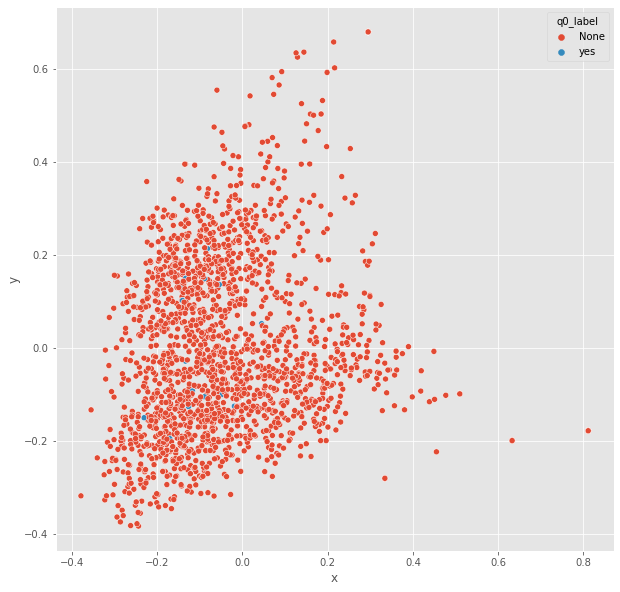

In [32]:
plt.rcParams['figure.figsize'] = (10, 10)
sns.scatterplot(data=hodge_clean, x='x', y='y', hue='q0_label')

In [35]:
# Skleran
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # for showing confusion matrix
from sklearn.preprocessing import MinMaxScaler # for feature scaling
from sklearn.semi_supervised import LabelPropagation # for assigning labels to unlabeled data

In [38]:
new_dict={"None": -1, 'no': 0, 'yes':1}

In [63]:
# Create a new target colum with labels. The 1's and 0's are original labels and -1 represents unlabeled data
hodge_clean['target_prop'] = hodge_clean.q0_label.apply(lambda x: new_dict[x])

In [64]:
hodge_clean.target_prop.value_counts()

-1    1982
 1      18
Name: target_prop, dtype: int64

In [65]:
import random
random_label = random.choices(range(len(hodge_clean.target_prop)), k=100)

In [66]:
res = []
for i in range(len(hodge_clean.target_prop)):
    if i not in random_label:
        res.append(hodge_clean.target_prop[i])
    else:
        if hodge_clean.target_prop[i] != 1:
            res.append(0)
        else:
            res.append(1)
    

In [67]:
hodge_clean['target_prop'] = res

In [68]:
hodge_clean.target_prop.value_counts()

-1    1885
 0      97
 1      18
Name: target_prop, dtype: int64

## Label Propagation

In [121]:
### Step 1 - Select data
X=hodge_clean[['x', 'y']]
y=hodge_clean['target_prop'].values


### Step 2 - Perform Min-Max scaling
scaler=MinMaxScaler()
X_scaled=scaler.fit_transform(X)


### Step 3 - Configure model parameters 
model_LP_knn = LabelPropagation(kernel='knn', # {'knn', 'rbf'} default='rbf'
                              #gamma=70, # default=20, Parameter for rbf kernel.
                              n_neighbors=10, # default=7, Parameter for knn kernel which is a strictly positive integer.
                              max_iter=10, # default=30, Maximum number of iterations allowed.
                              tol=0.0001, # default=1e-3, Convergence tolerance: threshold to consider the system at steady state.
                              n_jobs=-1, # default=None, The number of parallel jobs to run. -1 means using all processors. 
                             )

### Step 4 - Fit the model
LP_knn=model_LP_knn.fit(X_scaled, y)

# ### Step 5 - exclude observations with known records before evcaluating model performance
# df_eval=df[['Dependents_Flag', 'Dependents_Target']].copy() # Copy dataframe with dependents info
# df_eval['Predicted_label']=LP_knn.transduction_ # Attach model predictions
# df_eval=df_eval[df_eval['Dependents_Target']==-1] # Keep only records containing masked labels

/Users/cassie/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=10 was reached without convergence.
  warnings.warn(


In [122]:
hodge_clean['predicted'] = LP_knn.transduction_

In [123]:
hodge_clean.predicted.value_counts()

0    1780
1     220
Name: predicted, dtype: int64

In [124]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)

In [125]:
hodge_clean[(hodge_clean.predicted == 1)&(hodge_clean.target_prop == -1)]['Tweet'].shape

(202,)

In [126]:
res = 0
for i in hodge_clean[(hodge_clean.predicted == 1)&(hodge_clean.target_prop == -1)]['Tweet'].index:
    curr = hodge_clean[(hodge_clean.predicted == 1)&(hodge_clean.target_prop == -1)]['Tweet'][i]
    if 'vaccine' in curr:
        res += 1
        print(i)
    if 'covid' in curr:
        res +=1
        print(i)
    if 'mask' in curr:
        res +=1
        print(i)
res

698
1985
1985
1986
1986


5

In [127]:
hodge_clean.Tweet[1985]

'@PapaEbakuu Social Distancing &amp; masks is not science. If you understood how we get sick, they don’t work. Forcing people to take a vaccine after recovery from C19 is not science. Experimental drugs are not vaccines. Haven’t watched his special yet, but remember he’s just a comedian.'

In [128]:
hodge_clean.Tweet[1986]

'Social Distancing &amp; masks is not science. If you understood how we get sick, they don’t work. Forcing people to take a vaccine after recovery from C19 is not science. Experimental drugs are not vaccines. Haven’t watched his special yet, but remember he’s just a comedian. https://t.co/dhJ4rdKCRl'

In [130]:
### Step 1 - Select data
X=hodge_clean[['x', 'y']]
y=hodge_clean['target_prop'].values


### Step 2 - Perform Min-Max scaling
scaler=MinMaxScaler()
X_scaled=scaler.fit_transform(X)


### Step 3 - Configure model parameters 
model_LP_knn = LabelPropagation(kernel='knn', # {'knn', 'rbf'} default='rbf'
                              #gamma=70, # default=20, Parameter for rbf kernel.
                              n_neighbors=5, # default=7, Parameter for knn kernel which is a strictly positive integer.
                              max_iter=10, # default=30, Maximum number of iterations allowed.
                              tol=0.0001, # default=1e-3, Convergence tolerance: threshold to consider the system at steady state.
                              n_jobs=-1, # default=None, The number of parallel jobs to run. -1 means using all processors. 
                             )

### Step 4 - Fit the model
LP_knn=model_LP_knn.fit(X_scaled, y)

# ### Step 5 - exclude observations with known records before evcaluating model performance
# df_eval=df[['Dependents_Flag', 'Dependents_Target']].copy() # Copy dataframe with dependents info
# df_eval['Predicted_label']=LP_knn.transduction_ # Attach model predictions
# df_eval=df_eval[df_eval['Dependents_Target']==-1] # Keep only records containing masked labels

/Users/cassie/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/semi_supervised/_label_propagation.py:316: ConvergenceWarning: max_iter=10 was reached without convergence.
  warnings.warn(


In [131]:
hodge_clean['predicted'] = LP_knn.transduction_
hodge_clean.predicted.value_counts()

0    1705
1     295
Name: predicted, dtype: int64

In [132]:
res = 0
for i in hodge_clean[(hodge_clean.predicted == 1)&(hodge_clean.target_prop == -1)]['Tweet'].index:
    curr = hodge_clean[(hodge_clean.predicted == 1)&(hodge_clean.target_prop == -1)]['Tweet'][i]
    if 'vaccine' in curr:
        res += 1
        print(i)
    if 'covid' in curr:
        res +=1
        print(i)
    if 'mask' in curr:
        res +=1
        print(i)
res

698
1985
1985
1986
1986
1987


6

In [133]:
hodge_clean.Tweet[698]

'RT @brianeharrison: 🚨BREAKING: CMS just EXEMPTED officials hired to enforce their vaccine mandate...from the vaccine mandate! My office obt…'

In [134]:
hodge_clean.Tweet[1987]

"It’s not a vaccine, it’s an experimental drug. They change the definition of what a vaccine is in order to call it a vaccine, legally. Pharmaceutical companies got richer from a drug by yesterday's standards couldn’t be considered a vaccine. Conspiracy theory? No, it’s a fact! https://t.co/dhJ4rdKCRl"